# **Tutorial** - Time Series Prediction of Snow Water Equivalent (SWE) Using LSTM in PyTorch


First, we import all the necessary libraries such as `torch`, `numpy`, `pandas`, and others for data preprocessing, model building, and evaluation. These libraries are key for handling data, neural networks, and visualization.

In [1]:
import os
import time
import gdown
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data

from torch import nn
from tqdm.autonotebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

warnings.filterwarnings('ignore')
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32

<ipython-input-1-567ca1b71674>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## **Downloading zip files onto the drive**

In [ ]:
url = "https://drive.google.com/drive/folders/1YWvq4F1Y0mrZh5hAkBjaINEZeAFCBsgD?usp=sharing"
gdown.download_folder(url, quiet=True, use_cookies=False)

['/content/Cloud Implementation Tutorial/wrf-skagit-HUC10-mean.zip',
 '/content/Cloud Implementation Tutorial/wus-sr-skagit-HUC10-mean-swe.zip']

## **Unzipping Data Files**

Here, we unzip the datasets required for the analysis

In [ ]:
!unzip '/content/Cloud Implementation Tutorial/wrf-skagit-HUC10-mean.zip' -d '/content/wrf-skagit-HUC10-mean'
!unzip '/content/Cloud Implementation Tutorial/wus-sr-skagit-HUC10-mean-swe.zip' -d '/content/wus-sr-skagit-HUC10-mean-swe'

Archive:  /content/Cloud Implementation Tutorial/wrf-skagit-HUC10-mean.zip
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000504-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000505-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000506-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000507-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000508-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000509-mean.csv  
  inflating: /content/wrf-skagit-HUC10-mean/wrf-skagit-1711000511-mean.csv  
Archive:  /content/Cloud Implementation Tutorial/wus-sr-skagit-HUC10-mean-swe.zip
  inflating: /content/wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000504-mean-swe.csv  
  inflating: /content/wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000505-mean-swe.csv  
  inflating: /content/wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000506-mean-swe.csv  
  inflating: /content/wus-sr-sk

In [ ]:
# This function normalizes the data using the Z-score formula, which helps to standardize the features

def z_score_normalize(df):
	normalized_df = df.copy()

	for column in df.columns:
		column_mean = df[column].mean()
		column_std = df[column].std()
		normalized_df[column] = (df[column] - column_mean) / column_std

	return normalized_df

# This function filters and merges two datasets (WRF and WUS) based on date ranges and resamples the data. It saves the filtered data as a new CSV:

def filter_and_merge_data(wrf_file, wus_file, filter_start_date, filter_end_date, filtered_data_start_data, filtered_data_end_data):
    # read WRF data
    file_number = wrf_file.split('-')[5]
    wrf = pd.read_csv(wrf_file)
    wrf['time'] = pd.to_datetime(wrf['time'])
    wrf.set_index('time', inplace=True)

    # Filter based on time index range
    wrf_filtered = wrf.loc[(wrf.index > filter_start_date) & (wrf.index < filter_end_date)]

    # Resampling the data
    wrf_resampled = wrf_filtered.resample('D').mean()

    # read WUS data
    wus = pd.read_csv(wus_file)
    wus['time'] = pd.to_datetime(wus['time'])
    wus.set_index('time', inplace=True)

    # Filter based on time index range
    wus_filtered = wus.loc[wus.index < filter_end_date]

    # Merging the data
    data = pd.merge(wrf_resampled, wus_filtered, left_index=True, right_index=True, how='inner')
    data = data[['precip', 'tair', 'mean']]
    data.rename(columns={'mean': 'SWE_Post'}, inplace=True)

    # Save the merged data to a new CSV file
    try:
        data.to_csv(f'filtered_data/filtered_csv_{file_number}.csv')
        print('File Saved !!')
    except:
        print('File save failed !!')

    # Filter the final data based on the date range
    filtered_data = data.loc[(data.index >= filtered_data_start_data) & (data.index <= filtered_data_end_data)]

    return data, filtered_data

## **Creating Dataset for Time Series Prediction**

This function transforms time-series data into a format suitable for model training. It uses the lookback parameter to determine how many previous time steps to consider as input features

In [ ]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A pandas DataFrame of time series data
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset.iloc[i:(i + lookback), :2].values  # Select first two columns
        target = dataset.iloc[i + lookback, 2:].values  # Select the last column as target
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

## **Snow Model (LSTM Neural Network)**

This is a simple LSTM-based neural network model designed for predicting SWE_Post values. The model uses one LSTM layer followed by a linear layer and LeakyReLU activation.



In [ ]:
class SnowModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_class, num_layers, dropout):
        super(SnowModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, dropout=self.dropout, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_class)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        device = x.device
        hidden_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        cell_states = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm1(x, (hidden_states, cell_states))
        out = self.linear(out[:, -1, :])
        out = self.leaky_relu(out)
        return out

## **Training the Model**

This function trains the model on the training data for a specified number of epochs and batch size. It also prints the Root Mean Square Error (RMSE) every 10 epochs.

In [ ]:
def train_model(model, optimizer, loss_fn, X_train, y_train, n_epochs, batch_size):
	loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
	epoch_losses = []

	for epoch in  range(n_epochs):
		epoch_loss = 0.0
		model.train()
		for X_batch, y_batch in loader:
			y_pred = model(X_batch)
			loss = loss_fn(y_pred, y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			epoch_loss += loss.item()
		# Validation
		if epoch % 10 != 0:
			continue

		model.eval()

		with torch.no_grad():
			y_pred = model(X_train)
			train_rmse = np.sqrt(loss_fn(y_pred, y_train))
			print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}")

		epoch_losses.append(epoch_loss / len(loader))

	return epoch_losses

## **Predicting and Plotting Results**

This function predicts values on the training and test datasets and visualizes the predictions compared to the actual SWE_Post values.



In [ ]:
def predict(data, model, X_train,X_test, lookback, train_size):
	data = data.astype(object)

	with torch.no_grad():
		train_plot = np.full_like(data['SWE_Post'].values, np.nan, dtype=float)
		y_pred = model(X_train)
		print(y_pred.shape)
		y_pred_new = y_pred[:,  -1].unsqueeze(1)
		print(y_pred_new.shape)
		print(type(lookback),type(train_size))
		train_plot[lookback:train_size] = y_pred_new.numpy().flatten()

		# shift test predictions for plotting
		test_plot = np.full_like(data['SWE_Post'].values, np.nan, dtype=float)
		test_plot[train_size+lookback:len(data)] = model(X_test)[:,  -1].unsqueeze(1).numpy().flatten()

	# plot
	plt.figure(figsize=(12,  6))
	plt.plot(data.index, data['SWE_Post'], c='b', label='Actual')
	plt.plot(data.index, train_plot, c='r', label='Train Predictions')
	plt.plot(data.index[train_size+lookback:], test_plot[train_size+lookback:], c='g', label='Test Predictions')
	plt.legend()
	plt.xlabel('Date')
	plt.ylabel('SWE_Post')
	plt.title('SWE_Post Predictions')
	plt.show()

## **Model Evaluation**
This function evaluates the model using standard metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared score (R2).

In [ ]:
def evaluate_metrics(model, X_train, y_train, X_test, y_test):

	with torch.no_grad():
		y_train_pred = model(X_train)
		y_test_pred = model(X_test)

	train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
	test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())
	train_mae = mean_absolute_error(y_train.numpy(), y_train_pred.numpy())
	test_mae = mean_absolute_error(y_test.numpy(), y_test_pred.numpy())
	train_r2 = r2_score(y_train.numpy(), y_train_pred.numpy())
	test_r2 = r2_score(y_test.numpy(), y_test_pred.numpy())

	return  [train_mse, test_mse, train_mae, test_mae, train_r2, test_r2]

In [ ]:
def  get_csv_filenames(directory):
  """ Returns a sorted list of CSV filenames from the given directory."""
  return  sorted([f for f in os.listdir(directory)  if f.endswith('.csv')])

## **Running the Pipeline**

This section retrieves the filenames from the dataset directories, filters and merges data, and finally trains and evaluates the model.

 Files: wrf-skagit-HUC10-mean/wrf-skagit-1711000504-mean.csv and wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000504-mean-swe.csv
File save failed !!
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip      0
tair        0
SWE_Post    0
dtype: int64
6667 3285

Lookback: 180
Epoch 0: train RMSE 0.1078
Epoch 10: train RMSE 0.0680
Epoch 20: train RMSE 0.0522
Epoch 30: train RMSE 0.0232
Epoch 40: train RMSE 0.0147
Epoch 50: train RMSE 0.0143
Epoch 60: train RMSE 0.0110
Epoch 70: train RMSE 0.0091
Epoch 80: train RMSE 0.0098
Epoch 90: train RMSE 0.0078
Epoch 100: train RMSE 0.0090
Epoch 110: train RMSE 0.0119
Epoch 120: train RMSE 0.0068
Epoch 130: train RMSE 0.0099
Epoch 140: train RMSE 0.0064
Epoch 150: train RMSE 0.0061
Epoch 160: train RMSE 0.0062
Epoch 170: train RMSE 0.0057
Epoch 180: train RMSE 0.0081
Epoch 190: train RMSE 0.0071
torch.Size([6487, 1])
torch.Size([6487, 1])
<class 'int'> <class 'int'>


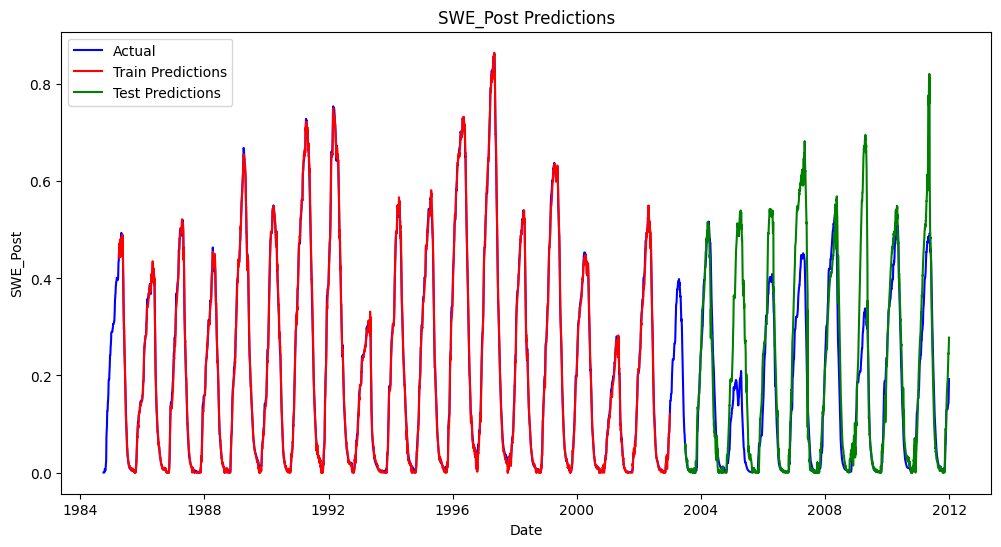

[7.0540795e-05, 0.011790501, 0.006283983, 0.06497909, 0.9985074996948242, 0.566952109336853]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000071      964.015772
1       180  snotel   test_mse  0.011791      964.015772
2       180  snotel  train_mae  0.006284      964.015772
3       180  snotel   test_mae  0.064979      964.015772
4       180  snotel   train_r2  0.998507      964.015772
5       180  snotel    test_r2  0.566952      964.015772
 Files: wrf-skagit-HUC10-mean/wrf-skagit-1711000505-mean.csv and wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000505-mean-swe.csv
File save failed !!
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip      0
tair        0
SWE_Post    0
dtype: int64
6667 3285

Lookback: 180
Epoch 0: train RMSE 0.0120
Epoch 10: train RMSE 0.0175
Epoch 20: train RMSE 0.0081
Epoch 30: train RMSE 0.0066
Epoch 40: train RMSE 0.0094
Epoch 50: train RMSE 0

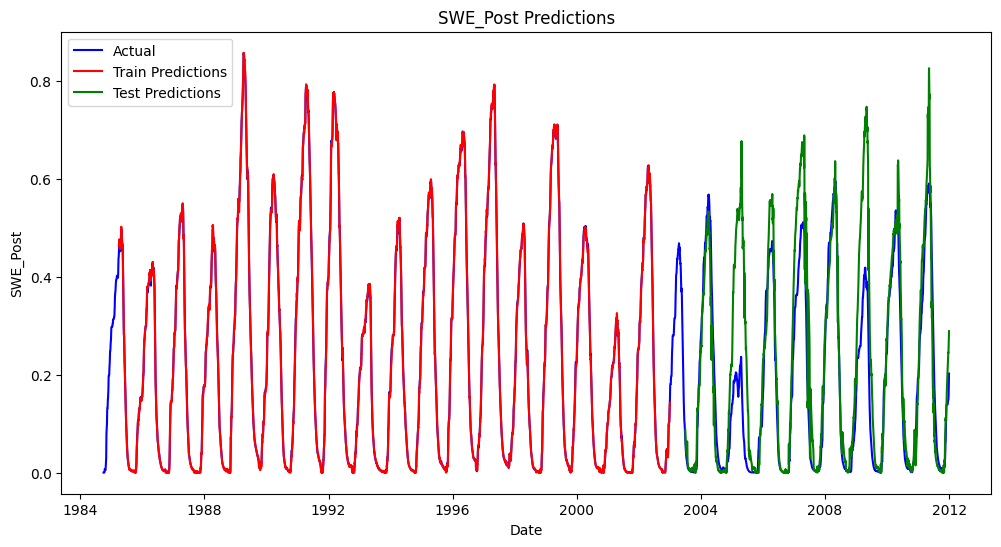

[1.7991551e-05, 0.012409762, 0.0031095569, 0.0687694, 0.9996545314788818, 0.64020174741745]
   Lookback Dataset     Metric     Value  Time Taken (s)
0       180  snotel  train_mse  0.000018      961.554777
1       180  snotel   test_mse  0.012410      961.554777
2       180  snotel  train_mae  0.003110      961.554777
3       180  snotel   test_mae  0.068769      961.554777
4       180  snotel   train_r2  0.999655      961.554777
5       180  snotel    test_r2  0.640202      961.554777
 Files: wrf-skagit-HUC10-mean/wrf-skagit-1711000506-mean.csv and wus-sr-skagit-HUC10-mean-swe/wus-sr-skagit-1711000506-mean-swe.csv
File save failed !!
precip      0
tair        0
SWE_Post    0
dtype: int64
Empty DataFrame
Columns: [precip, tair, SWE_Post]
Index: []
precip      0
tair        0
SWE_Post    0
dtype: int64
6667 3285

Lookback: 180
Epoch 0: train RMSE 0.0156
Epoch 10: train RMSE 0.0102
Epoch 20: train RMSE 0.0101
Epoch 30: train RMSE 0.0087
Epoch 40: train RMSE 0.0072
Epoch 50: train RMSE 0.

In [ ]:
# Define the hyperparameters
input_size=2
hidden_size=2**6
num_class=1
num_layers=1
dropout = 0.5

learning_rate = 1e-3 #3e-3
n_epochs = 30
train_size_fraction = 0.67

lookback_values =  [180]
def get_csv_filenames(directory):
    """
    Returns a sorted list of CSV filenames from the given directory.
    """
    return sorted([f for f in os.listdir(directory) if f.endswith('.csv')])

# Define the directories containing the CSV files
directory1 = 'wrf-skagit-HUC10-mean'
directory2 = 'wus-sr-skagit-HUC10-mean-swe'

# Get CSV filenames from both directories
filenames1 = get_csv_filenames(directory1)
filenames2 = get_csv_filenames(directory2)

# Ensure that both directories have the same number of files and their names match up correctly
assert len(filenames1) == len(filenames2), "Mismatch in the number of CSV files between the directories."

model_snotel = SnowModel(input_size, hidden_size, num_class, num_layers, dropout)
optimizer_snotel = optim.Adam(model_snotel.parameters())
loss_fn_snotel = nn.MSELoss()

# List the files together, assuming they are related in chronological order and should be compared one-to-one
for file1, file2 in zip(filenames1, filenames2):
    wrf_file = os.path.join(directory1, file1)
    wus_file = os.path.join(directory2, file2)
    print(f" Files: {wrf_file} and {wus_file}")

    # Example usage of filter_and_merge_data
    filter_start_date = '1984-10-01'
    filter_end_date = '2011-12-31'
    filtered_data_start_data = '2005-01-01'
    filtered_data_end_data = '2007-12-31'

    # Assuming filter_and_merge_data is a function you have defined elsewhere
    data, filtered_data = filter_and_merge_data(wrf_file, wus_file, filter_start_date, filter_end_date, filtered_data_start_data, filtered_data_end_data)

    # train-test split for time series

    print(data.isna().sum())
    data = data.fillna(method='bfill')

    nan_rows = data[data.isna().any(axis=1)]
    print(nan_rows)

    print(data.isna().sum())
    train_size_main = int(len(data) * 0.67)
    test_size_main = len(data) - train_size_main
    train_main, test_main = data[:train_size_main], data[train_size_main:]

    print(train_size_main,test_size_main)


    # train-test split for time series
    test_size_filtered = int(len(filtered_data))
    test_filtered = filtered_data[:train_size_main]


    # Usage example
    lookback_values =  [180]
    results = []

    for lookback in lookback_values:
        print(f"\nLookback: {lookback}")
        start_time = time.time()

        # Snotel dataset
        X_train_snotel, y_train_snotel = create_dataset(train_main, lookback)
        X_test_snotel, y_test_snotel = create_dataset(test_main, lookback)


        train_model(model_snotel, optimizer_snotel, loss_fn_snotel, X_train_snotel, y_train_snotel, n_epochs=200, batch_size=8)
        predict(data,model_snotel,  X_train_snotel,X_test_snotel, lookback, train_size_main)
        snotel_metrics = evaluate_metrics(model_snotel, X_train_snotel, y_train_snotel, X_test_snotel, y_test_snotel)
        print(snotel_metrics)
        elapsed_time = time.time() - start_time

        results.append([lookback, 'snotel', 'train_mse', snotel_metrics[0], elapsed_time])
        results.append([lookback, 'snotel', 'test_mse', snotel_metrics[1], elapsed_time])
        results.append([lookback, 'snotel', 'train_mae', snotel_metrics[2], elapsed_time])
        results.append([lookback, 'snotel', 'test_mae', snotel_metrics[3], elapsed_time])
        results.append([lookback, 'snotel', 'train_r2', snotel_metrics[4], elapsed_time])
        results.append([lookback, 'snotel', 'test_r2', snotel_metrics[5], elapsed_time])


    # Create a DataFrame for the results
    df_results = pd.DataFrame(results, columns=['Lookback', 'Dataset', 'Metric', 'Value', 'Time Taken (s)'])

    # Print the DataFrame
    print(df_results)